In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Imports

In [ ]:
import tensorflow as tf
import numpy as np

from skimage import color
from skimage import io

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset

In [ ]:
%tensorflow_version 2.x

##Cargar Dataset

In [ ]:
# Ruta Raiz
path = "/content/drive/MyDrive/REDESyDL/Miniproyecto3"

# Ruta entrada
inpath = path + "/Entrada"

# Ruta salida
outpath = path + "/Salida"

# Ruta CheckPoints
checkpath = path + "/CheckPoints"

imgurls = !ls -1 "{inpath}"
imgurls = [item.replace("'", "") for item in imgurls]

n = 160
train_n = round(n*0.80)

# Lista random
randurls = np.copy(imgurls)

np.random.seed(23)
np.random.shuffle(randurls)

# Partición data
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))

160 128 32


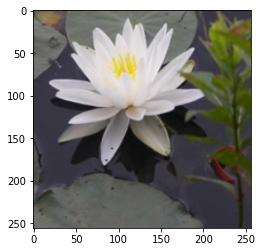

In [ ]:
img_width = 256
img_height = 256

# Rescalar imagenes
def resize(inimg, tgimg, heigth, width):
  inimg = tf.image.resize(inimg, [heigth, width])
  tgimg = tf.image.resize(tgimg, [heigth, width])

  return inimg, tgimg

# Normalizar (0, 1)
def normalizar(inimg, tgimg):
  inimg = (inimg/256)
  tgimg = (tgimg/256)

  return inimg, tgimg

# Aumentación de datos_ Random Crop + Flip
@tf.function
def random_jitter(inimg, tgimg):
  
  inimg, tgimg = resize(inimg, tgimg, 286, 286)

  stacked_image = tf.stack([inimg, tgimg], axis = 0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, img_height, img_width, 3])

  inimg, tgimg = cropped_image[0], cropped_image[1]

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  return inimg, tgimg

def load_image(filename, augment = True):
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(inpath + "/" + filename)), tf.float32)[..., :3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(outpath + "/" + filename)), tf.float32)[..., :3]

  inimg, tgimg = resize(inimg, tgimg, img_height, img_width)

  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)

  inimg, tgimg = normalizar(inimg, tgimg)

  return inimg, tgimg

def load_train_img(filename):
  return load_image(filename, True)
  
def load_test_img(filename):
  return load_image(filename, False)
  

plt.imshow((load_train_img(randurls[0])[1]))

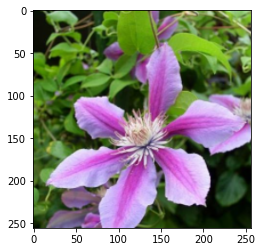

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(4)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_train_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(4)

for inimg, tgimg in train_dataset.take(5):
  plt.imshow(((tgimg[0,...])))

## Diseño Pix2Pix

In [ ]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample (filters, apply_batchnorm = True):

  result = Sequential()

  inicializer = tf.random_normal_initializer(0,0.02)

  #Capa convolucional
  result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=inicializer,
                    use_bias=not apply_batchnorm))
  
  if apply_batchnorm:
    # Capa BatchNorm
    result.add(BatchNormalization())

  # Capa de Activation
  result.add(LeakyReLU())

  return result
  
downsample (64)

In [ ]:
from keras.layers.advanced_activations import ReLU
def upsample (filters, apply_dropout = False):

  result = Sequential()

  inicializer = tf.random_normal_initializer(0,0.02)

  #Capa convolucional
  result.add(Conv2DTranspose(filters,
                            kernel_size=4,
                            strides=2,
                            padding="same",
                            kernel_initializer=inicializer,
                            use_bias=False))
  
  result.add(BatchNormalization())

  if apply_dropout:
    # Capa Dropout
    result.add(Dropout(0.5))

  # Capa de Activation
  result.add(ReLU())

  return result
  
upsample (64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


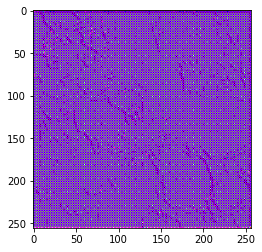

In [ ]:
def Generador():

  inputs = tf.keras.layers.Input(shape=[None,None,3])

  down_stack = [
                downsample(64, apply_batchnorm=False),  #(bs, 128, 128, 64)
                downsample(128),                        #(bs, 64, 64, 128)
                downsample(256),                        #(bs, 32, 32, 256)
                downsample(512),                        #(bs, 16, 16, 512)
                downsample(512),                        #(bs, 8,  8,  512)
                downsample(512),                        #(bs, 4,  4,  512)
                downsample(512),                        #(bs, 2,  2,  512)
                downsample(512),                        #(bs, 1,  1,  512)
                ]

  up_stack = [
              upsample(512, apply_dropout=True),      #(bs, 2,    2,  1024)
              upsample(512, apply_dropout=True),      #(bs, 4,    4,  1024)
              upsample(512, apply_dropout=True),      #(bs, 8,    8,  1024)
              upsample(512),                          #(bs, 16,   16,  1024)
              upsample(256),                          #(bs, 32,   32,  512)
              upsample(128),                          #(bs, 64,   64,  256)
              upsample(64),                           #(bs, 128,  128, 128)

  ]

  inicializer = tf.random_normal_initializer(0, 0.02)

  last = Conv2DTranspose(filters=3,
                         kernel_size=4,
                         strides=2,
                         padding="same",
                         kernel_initializer = inicializer,
                         activation="tanh")
  
  x = inputs
  s = []

  concat = Concatenate()

  for down in down_stack:
    x = down(x)
    s.append(x)

  s = reversed(s[:-1])

  for up, sk in zip(up_stack, s):
    x = up(x)
    x = concat([x,sk])

  last = last (x)

  return Model(inputs = inputs, outputs = last)

generator = Generador()
gen_output = generator(((inimg+1)*255), training = False)
plt.imshow(gen_output[0,...])

TensorShape([4, 16, 16, 1])

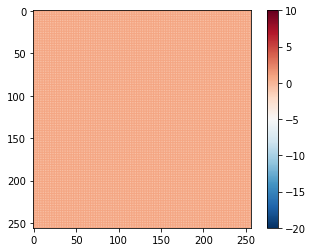

In [ ]:
def Discriminador ():

  ini = Input(shape=[None,None,3], name="input_img")
  gen = Input(shape=[None,None,3], name="gen_img")

  con = concatenate([ini,gen])

  inicializer = tf.random_normal_initializer(0, 0.02)

  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 =downsample(64)(down1)
  down3 =downsample(64)(down2)
  down4 =downsample(64)(down3)

  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer = inicializer,
                                padding="same")(down4)

  return tf.keras.Model(inputs=[ini,gen], outputs=last)

discriminador = Discriminador()

disc_out = discriminador([((inimg+1)*255), gen_output], training = False)
plt.imshow(gen_output[0,...,-1], vmin=-20, vmax=10, cmap='RdBu_r')
plt.colorbar()
disc_out.shape

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discrimador_loss(disc_real_output, disc_generated_output):
  
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_generated_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_real_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss


In [ ]:
LAMBA = 100

def generator_loss (disc_generated_output, gen_output, target):

  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  l1_loss = tf.reduce_mean(tf.abs(target-gen_output))

  total_gen_loss = gan_loss + (LAMBA * l1_loss)

  return total_gen_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adamax(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adamax(2e-4, beta_1=0.5)

checkpoint_prefix = os.path.join(checkpath, "chkpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminador = discriminador)

# checkpoint.restore(tf.train.latest_checkpoint(checkpath)).assert_consumed()

In [ ]:
def generate_images(model, test_input, tar, save_filename = False, display_imgs = True):

  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(path + '/SalidaB/' +save_filename + '.jpg', prediction[0,...])

  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # Getting the pixel values in the [0, 1] range to plot.
      plt.imshow(display_list[i])
      plt.axis('off')
  plt.show()

In [ ]:
@tf.function()
def train_step(input_image, target):

  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

    output_img = generator(input_image, training=True)

    output_gen_discr = discriminador([output_img, input_image], training=True)

    output_trg_discr = discriminador([target, input_image], training=True)

    discr_loss = discrimador_loss(output_trg_discr, output_gen_discr)

    gen_loss = generator_loss(output_gen_discr, output_img, target)


    generador_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)

    discriminador_grads = discr_tape.gradient(discr_loss, discriminador.trainable_variables)

    generator_optimizer.apply_gradients(zip(generador_grads,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminador_grads,
                                              discriminador.trainable_variables))

 # with summary_writer.as_default():
 #   tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
 #   tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
 #   tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
 #   tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):

    imgi = 0

    for input_image, target in dataset:
      print('epoch ' + str(epoch) + ' train - '+ str(imgi)+'/'+str(len(tr_urls)))
      imgi+=1
      train_step(input_image, target)

      clear_output(wait=True)

    imgi = 0
    for inp, tar in test_dataset.take(10):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs = True)
      imgi += 1
    if (epoch +1) %25 ==0:
      checkpoint.save(file_prefix = checkpoint_prefix)
  

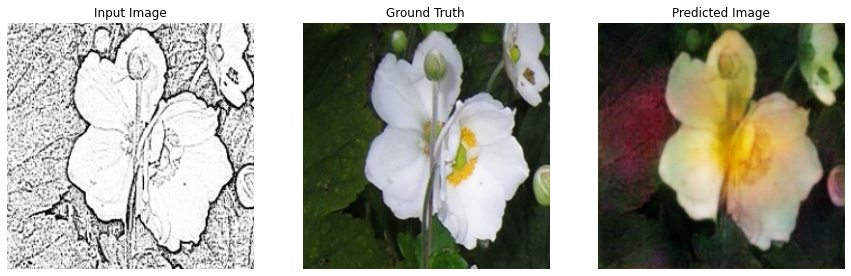

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


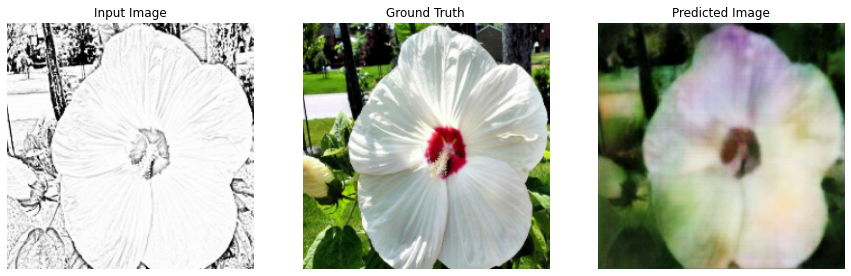

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


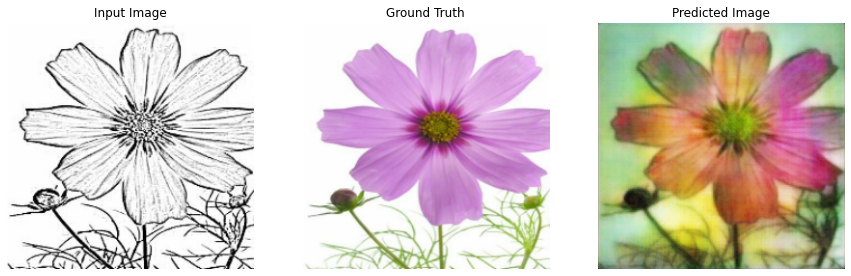

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


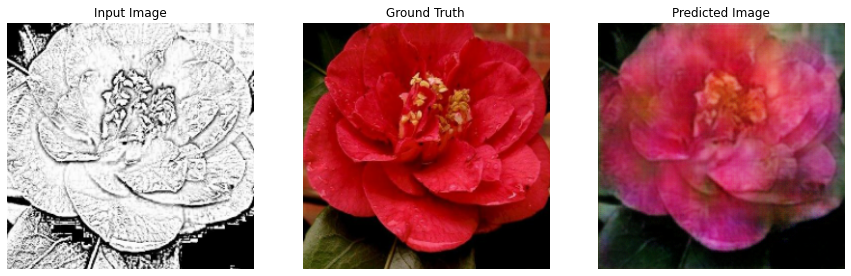

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


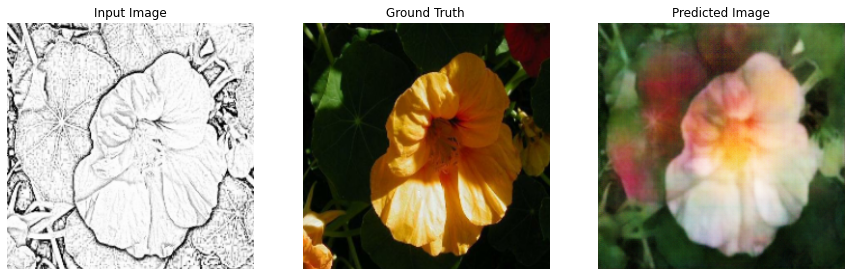

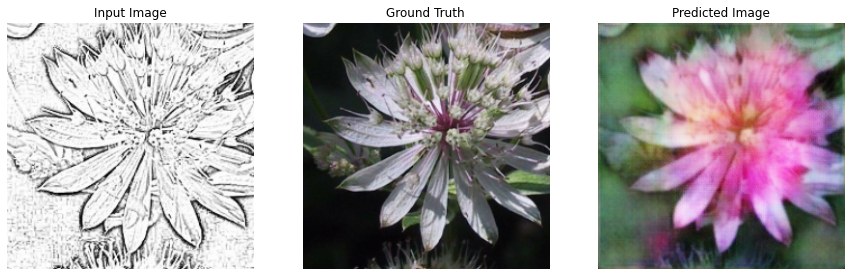

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


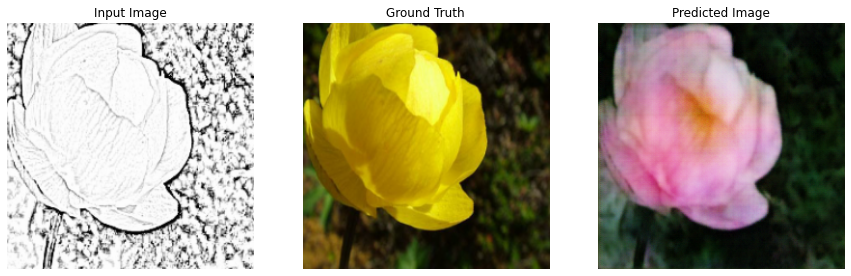

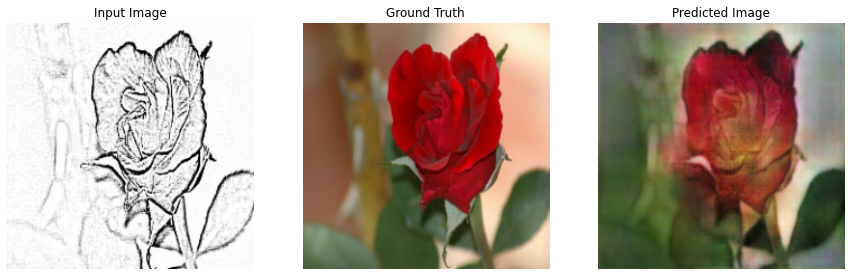

In [ ]:
train(train_dataset, 300)

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpath)).assert_consumed()